In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [38]:
def Kmeans(X, k=3, max_iter=1000):
	"""
	X: data
	k: number of clusters
	max_iter: maximum number of iterations
	"""
	key = X[np.random.choice(X.shape[0], k, replace=False)]
	for _ in range(max_iter):
		dis = np.linalg.norm(X[:, None, :] - key[None, :, :], axis=2)
		typ = np.argmin(dis, axis=1)
		key_ = np.array([np.mean(X[typ == i], axis=0) for i in range(k)])
		if np.all(np.linalg.norm(key - key_, axis=1) < 1e-5):
			break
		key = key_
	return typ, key

def __normal_distribution(X, mu, sigma):
	"""
	X: data
	mu: mean
	sigma: covariance matrix
	Note that the result ignored the constant term (2*pi) ** (-0.5)
	"""
	return np.linalg.det(sigma) ** (-0.5) * np.exp(-0.5 * np.sum((X - mu) @ np.linalg.inv(sigma) * (X - mu), axis=1))
def GMM(X, k=3, max_iter=1000):
	"""
	X: data
	k: number of clusters
	max_iter: maximum number of iterations
	"""
	n, d = X.shape
	mu = X[np.random.choice(n, k, replace=False)]
	sigma = np.array([np.eye(d) for _ in range(k)])
	pi = np.ones(k) / k
	for _ in range(max_iter):
		# E step
		p = np.array([pi[i] * __normal_distribution(X, mu[i], sigma[i]) for i in range(k)])
		p /= np.sum(p, axis=0, keepdims=True)
		# M step
		pi = np.mean(p, axis=1)
		mu = np.sum(p[:, :, None] * X[None, :, :], axis=1) / np.sum(p, axis=1, keepdims=True)
		sigma = np.sum(p[:, :, None, None] * (X[None, :, :, None] - mu[:, None, :, None]) * (X[None, :, None, :] - mu[:, None, None, :]), axis=1) / np.sum(p, axis=1).reshape(-1, 1, 1)
	return np.argmax(p, axis=0), mu

In [39]:
def silhouette(X, typ):
	"""
	X: data
	typ: cluster type
	"""
	n = X.shape[0]
	dis = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)
	dis_cluster = np.array([np.mean(dis[typ == i], axis=0) for i in range(np.max(typ) + 1)])
	a = np.array([dis_cluster[typ[i], i] for i in range(n)])
	b = np.array([np.min(np.delete(dis_cluster[:, i], typ[i])) for i in range(n)])
	return np.mean((b - a) / np.maximum(a, b))

def rand_index(cls1, cls2):
	"""
	cls1: cluster type 1
	cls2: cluster type 2
	"""
	n = cls1.shape[0]
	a = np.sum((cls1[:, None] == cls1[None, :]) & (cls2[:, None] == cls2[None, :])) - n
	b = np.sum((cls1[:, None] != cls1[None, :]) & (cls2[:, None] != cls2[None, :]))
	return (a + b) / (n * (n - 1))

def __entropy(cls):
	n = cls.shape[0]
	typ = np.unique(cls)
	return -np.sum([np.sum(cls == i) / n * np.log2(np.sum(cls == i) / n) for i in typ])
def __mutual_info(cls1, cls2):
	n = cls1.shape[0]
	typ1, typ2 = np.unique(cls1), np.unique(cls2)
	return np.sum([
		np.sum((cls1 == i) & (cls2 == j)) / n * # P(i, j)
		np.log2(n * np.sum((cls1 == i) & (cls2 == j)) / np.sum(cls1 == i) / np.sum(cls2 == j)) # log(P(i, j) / P(i) / P(j))
		for i in typ1 for j in typ2 if np.sum((cls1 == i) & (cls2 == j)) > 0
	])
def NMI(cls1, cls2):
	"""
	cls1: cluster type 1
	cls2: cluster type 2
	"""
	return __mutual_info(cls1, cls2) / np.sqrt(__entropy(cls1) * __entropy(cls2))

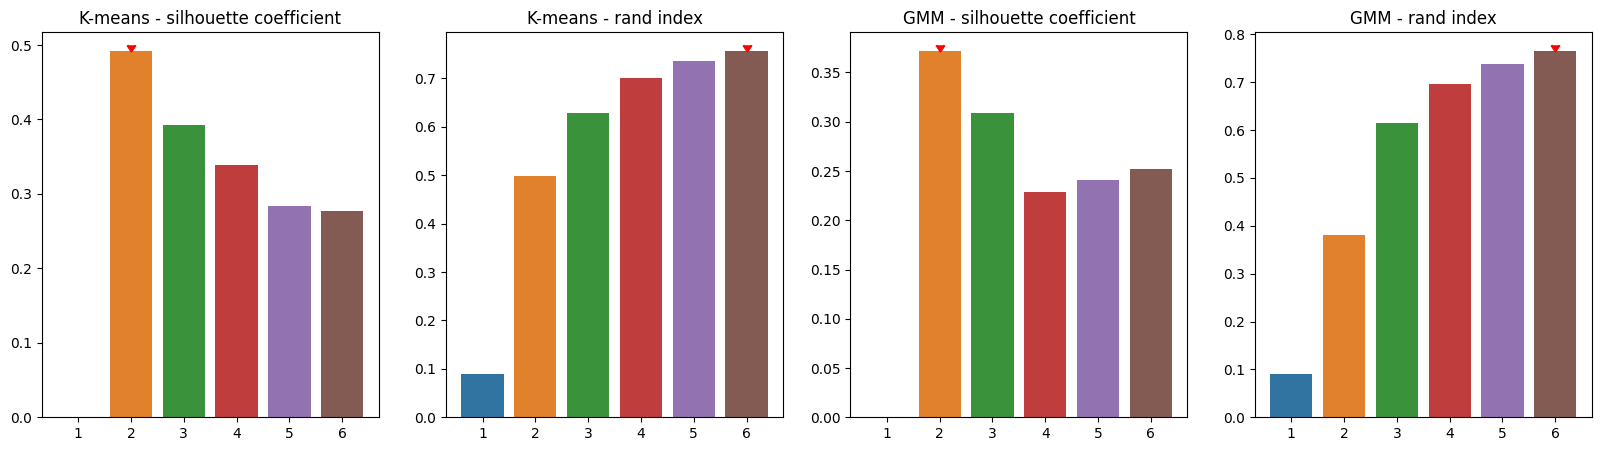

In [40]:
df = pd.read_csv("Vowel.csv")
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
uni = list(np.unique(y))
y = np.array([uni.index(i) for i in y])

# K-means
SI_k = []
RI_k = []
for k in range(1, 7):
	typ, key = Kmeans(X, k=k)
	SI_k.append(silhouette(X, typ) if k > 1 else 0)
	RI_k.append(rand_index(y, typ))
# GMM
SI_g = []
RI_g = []
for k in range(1, 7):
	typ, key = GMM(X, k=k)
	SI_g.append(silhouette(X, typ) if k > 1 else 0)
	RI_g.append(rand_index(y, typ))

# plot
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
sns.barplot(x=np.arange(1, 7), y=SI_k)
plt.scatter(np.argmax(SI_k), np.max(SI_k), marker=7, color="red")
plt.title("K-means - silhouette coefficient")
plt.subplot(1, 4, 2)
sns.barplot(x=np.arange(1, 7), y=RI_k)
plt.scatter(np.argmax(RI_k), np.max(RI_k), marker=7, color="red")
plt.title("K-means - rand index")
plt.subplot(1, 4, 3)
sns.barplot(x=np.arange(1, 7), y=SI_g)
plt.scatter(np.argmax(SI_g), np.max(SI_g), marker=7, color="red")
plt.title("GMM - silhouette coefficient")
plt.subplot(1, 4, 4)
sns.barplot(x=np.arange(1, 7), y=RI_g)
plt.scatter(np.argmax(RI_g), np.max(RI_g), marker=7, color="red")
plt.title("GMM - rand index")
plt.show()

* NMI on $k=2, 6$, respectively, since both models give silhouette coef's maximum at $k=2$ ,and $RI$'s maximum at $k=6$.

In [41]:
print(f" Silhouette coefficient | K-means | k=2 | NMI = {NMI(y, Kmeans(X, k=2)[0])}")
print(f" Silhouette coefficient |   GMM   | k=2 | NMI = {NMI(y, GMM(X, k=2)[0])}")
print(f" Random index | k=6 | K-means | NMI = {NMI(y, Kmeans(X, k=6)[0])}")
print(f" Random index | k=6 |   GMM   | NMI = {NMI(y, GMM(X, k=6)[0])}")

 Silhouette coefficient | K-means | k=2 | NMI = 0.0
 Silhouette coefficient |   GMM   | k=2 | NMI = 0.0022286851113870513
 Random index | k=6 | K-means | NMI = 0.03972948044899669
 Random index | k=6 |   GMM   | NMI = 0.07475890577922024
